#  Wound Infection Detection


## 📦 Part 1: Import Libraries


In [1]:
# ============================================================================
# Import all required libraries
# ============================================================================

try:
    import json
    import cv2
    import numpy as np
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    from pathlib import Path
    from typing import Dict, List, Tuple
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    from tqdm import tqdm
    import random
    import yaml
    import matplotlib.pyplot as plt
    
    # PyTorch Vision
    import torchvision
    from torchvision.models.detection import maskrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
    
    print("=" * 60)
    print("✓ All libraries imported successfully!")
    print("=" * 60)
    print(f"PyTorch: {torch.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"CUDA: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Device: {torch.cuda.get_device_name(0)}")
    print("=" * 60)
    
except ValueError as e:
    if "numpy.dtype size changed" in str(e):
        print("=" * 60)
        print("❌ خطأ: تعارض بين numpy و scipy")
        print("=" * 60)
        print("\n🔧 الحل:")
        print("   1. شغّل هذه الأوامر في Terminal:")
        print("      pip install --upgrade --force-reinstall numpy scipy")
        print("   2. أو شغّل Part 0 مرة أخرى")
        print("   3. أعد تشغيل Kernel: Kernel → Restart")
        print("=" * 60)
        raise
    else:
        raise
        
except ImportError as e:
    print("=" * 60)
    print("❌ خطأ في استيراد المكتبات!")
    print("=" * 60)
    print(f"الخطأ: {e}")
    print("\n🔧 الحل:")
    print("   1. شغّل Part 0 أولاً (تثبيت المكتبات)")
    print("   2. أعد تشغيل Kernel: Kernel → Restart")
    print("=" * 60)
    raise


✓ All libraries imported successfully!
PyTorch: 2.5.1+cu121
NumPy: 2.3.5
CUDA: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU


## ⚙️ Part 2: Configuration


In [2]:
# ============================================================================
# تثبيت المكتبات المطلوبة
# ============================================================================

import sys
import subprocess

def install_package(package):
    """تثبيت مكتبة واحدة مع معالجة الأخطاء"""
    try:
        print(f"  📦 {package}...", end=" ", flush=True)
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", package],
            capture_output=True,
            text=True,
            check=False
        )
        if result.returncode == 0:
            print("✓")
            return True
        else:
            print("⚠️ (فشل - قد تكون موجودة بالفعل)")
            return False
    except Exception as e:
        print(f"❌ خطأ: {e}")
        return False

print("=" * 60)
print("📦 تثبيت المكتبات...")
print("=" * 60)

# تثبيت setuptools و wheel أولاً (مهم لـ Python 3.13)
print("\n[1/3] تثبيت setuptools و wheel...")
install_package("setuptools")
install_package("wheel")

# تثبيت numpy و scipy (إصدارات تدعم Python 3.13)
print("\n[2/3] تثبيت numpy و scipy...")
install_package("numpy>=1.26.0")
install_package("scipy>=1.11.0")

# تثبيت باقي المكتبات (واحدة تلو الأخرى)
print("\n[3/3] تثبيت باقي المكتبات...")
packages = [
    "torch", "torchvision",
    "opencv-python", "Pillow", "albumentations",
    "pandas", "matplotlib", "seaborn",
    "tqdm", "scikit-learn", "pycocotools",
    "pyyaml", "jupyter", "ipywidgets"
]

for package in packages:
    install_package(package)

print("\n" + "=" * 60)
print("✓ تم التثبيت!")
print("=" * 60)
print("⚠️ أعد تشغيل Kernel: Kernel → Restart")
print("=" * 60)



# ============================================================================
# Configuration - يمكنك تعديل هذه القيم
# ============================================================================

import platform

CONFIG = {
    # Data - مسارات نسبية من notebooks/ إلى project root
    'data_root': '../data',  # مجلد البيانات الأصلية (للتحقق validation)
    # ملاحظة: البيانات المعززة تُستخدم للتدريب (../data/augmented/)
    'image_size': [1024, 1024],
    'num_classes': 9,  # 16 wound types + background
    'batch_size': 2,
    # على Windows، استخدم num_workers=0 لتجنب مشاكل multiprocessing
    'num_workers': 0 if platform.system() == 'Windows' else 4,
    
    # Training
    'epochs': 50,
    'learning_rate': 0.0005,  # Reduced from 0.001 to prevent NaN loss
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Early stopping
    'early_stop_patience': 7,
    'early_stop_min_delta': 0.001,
    
    # Training stability
    'loss_clip_max': 100.0,
    'loss_skip_threshold': 1000.0,
    'skip_invalid_targets': True,
    
    # Medical Augmentation Strategy Settings
    'use_medical_augmentation': True,  # Enable comprehensive medical augmentation
    'preserve_marker': True,           # Preserve marker geometry (critical for area measurements)
    'intensity': "moderate",           # Augmentation intensity: "light", "moderate", "aggressive"
    
    
    # Medical Augmentation Strategy Settings
    'use_medical_augmentation': True,  # Enable comprehensive medical augmentation
    'preserve_marker': True,           # Preserve marker geometry (critical for area measurements)
    'intensity': "moderate",           # Augmentation intensity: "light", "moderate", "aggressive"
    
    
    # Splits
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    
    # Paths - مسارات نسبية من notebooks/ إلى project root
    'checkpoints_dir': '../checkpoints_medical_aug',  # مجلد checkpoints في الجذر
    'results_dir': '../results',  # مجلد results في الجذر
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print(f"\n✓ Device: {CONFIG['device']}")


📦 تثبيت المكتبات...

[1/3] تثبيت setuptools و wheel...
  📦 setuptools... ✓
  📦 wheel... ✓

[2/3] تثبيت numpy و scipy...
  📦 numpy>=1.26.0... ✓
  📦 scipy>=1.11.0... ✓

[3/3] تثبيت باقي المكتبات...
  📦 torch... ✓
  📦 torchvision... ✓
  📦 opencv-python... ✓
  📦 Pillow... ✓
  📦 albumentations... ✓
  📦 pandas... ✓
  📦 matplotlib... ✓
  📦 seaborn... ✓
  📦 tqdm... ✓
  📦 scikit-learn... ✓
  📦 pycocotools... ✓
  📦 pyyaml... ✓
  📦 jupyter... ✓
  📦 ipywidgets... ✓

✓ تم التثبيت!
⚠️ أعد تشغيل Kernel: Kernel → Restart
Configuration:
  data_root: ../data
  image_size: [1024, 1024]
  num_classes: 9
  batch_size: 2
  num_workers: 0
  epochs: 50
  learning_rate: 0.0005
  device: cuda
  early_stop_patience: 7
  early_stop_min_delta: 0.001
  loss_clip_max: 100.0
  loss_skip_threshold: 1000.0
  skip_invalid_targets: True
  use_medical_augmentation: True
  preserve_marker: True
  intensity: moderate
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15
  checkpoints_dir: ../checkpoints_medical_aug
  resu

## 📊 Part 3: Data Processing


In [3]:
# ============================================================================
# 3.1 CVAT to COCO Converter
# ============================================================================

def convert_cvat_to_coco(data_root: str, output_file: str):
    """تحويل تعليقات CVAT إلى صيغة COCO"""
    
    # Convert to absolute path - handle relative paths correctly
    current_dir = Path.cwd()
    data_root = Path(data_root)
    
    # Handle relative paths - notebook is in notebooks/ directory
    if not data_root.is_absolute():
        # If path starts with ../, it's already relative to parent
        if str(data_root).startswith('../'):
            data_root = current_dir.parent / data_root
        # If path is relative and we're in notebooks/, go up one level
        elif current_dir.name == 'notebooks':
            data_root = current_dir.parent / data_root
        else:
            data_root = current_dir / data_root
    
    data_root = data_root.resolve()
    
    # Check if project.json exists
    project_file = data_root / "project.json"
    if not project_file.exists():
        print("=" * 60)
        print("❌ خطأ: ملف project.json غير موجود!")
        print("=" * 60)
        print(f"المسار المطلوب: {project_file}")
        print(f"المسار الحالي: {current_dir}")
        print(f"data_root: {data_root}")
        print("\n🔧 الحل:")
        print("   1. تأكد أن مجلد 'data' موجود في المجلد الرئيسي للمشروع")
        print("   2. تأكد أن 'data/project.json' موجود")
        print("   3. أو عدّل CONFIG['data_root'] في Part 2")
        print("=" * 60)
        raise FileNotFoundError(f"project.json not found at {project_file}")
    
    # Load project info
    with open(project_file, 'r', encoding='utf-8') as f:
        project_info = json.load(f)
    
    # Create label mapping
    label_map = {label['name']: idx for idx, label in enumerate(project_info['labels'])}
    
    # Initialize COCO structure
    coco_data = {
        'images': [],
        'annotations': [],
        'categories': [{'id': idx, 'name': name} for name, idx in label_map.items()]
    }
    
    image_id = 0
    annotation_id = 0
    
    # Process all tasks
    task_folders = sorted([f for f in data_root.iterdir() if f.is_dir() and f.name.startswith('task_')])
    
    print(f"Processing {len(task_folders)} tasks...")
    
    for task_folder in tqdm(task_folders):
        try:
            # Load annotations
            with open(task_folder / "annotations.json", 'r', encoding='utf-8') as f:
                annotations = json.load(f)
            
            # Get images
            data_dir = task_folder / "data"
            image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))
            
            for img_file in image_files:
                # Read image to get size
                img = cv2.imread(str(img_file))
                if img is None:
                    continue
                
                h, w = img.shape[:2]
                
                # Add image
                is_infected = '-not-' not in img_file.name.lower()
                coco_data['images'].append({
                    'id': image_id,
                    'file_name': str(img_file.relative_to(data_root)),
                    'width': w,
                    'height': h,
                    'infection_status': is_infected
                })
                
                # Add annotations for this image (first frame)
                if len(annotations) > 0 and 'shapes' in annotations[0]:
                    for shape in annotations[0]['shapes']:
                        if shape['type'] != 'polygon' or shape['label'] not in label_map:
                            continue
                        
                        # Convert polygon points - handle different formats
                        points = shape['points']
                        
                        # Check if points is a list of lists or a flat list
                        if not isinstance(points, list):
                            continue
                        
                        # Handle case where points might be a flat list of floats
                        if len(points) > 0 and isinstance(points[0], (int, float)):
                            # Flat list: [x1, y1, x2, y2, ...]
                            if len(points) % 2 != 0:
                                continue
                            points = [[points[i], points[i+1]] for i in range(0, len(points), 2)]
                        
                        # Ensure points is a list of [x, y] pairs
                        if not all(isinstance(p, (list, tuple)) and len(p) == 2 for p in points):
                            continue
                        
                        polygon = [coord for point in points for coord in point]
                        
                        # Calculate bbox
                        x_coords = [p[0] for p in points]
                        y_coords = [p[1] for p in points]
                        x_min, x_max = min(x_coords), max(x_coords)
                        y_min, y_max = min(y_coords), max(y_coords)
                        bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                        
                        # Calculate area
                        area = (x_max - x_min) * (y_max - y_min)
                        
                        coco_data['annotations'].append({
                            'id': annotation_id,
                            'image_id': image_id,
                            'category_id': label_map[shape['label']],
                            'segmentation': [polygon],
                            'area': area,
                            'bbox': bbox,
                            'iscrowd': 0
                        })
                        annotation_id += 1
                
                image_id += 1
        
        except Exception as e:
            print(f"Error processing {task_folder.name}: {e}")
    
    # Save COCO file
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(coco_data, f, indent=2)
    
    print(f"\n✓ Done! Saved to {output_file}")
    print(f"✓ Total images: {len(coco_data['images'])}")
    print(f"✓ Total annotations: {len(coco_data['annotations'])}")
    
    return coco_data

print("✓ Converter function defined!")


# ============================================================================
# 3.2 Dataset Splitter
# ============================================================================

def split_dataset(coco_file: str, output_dir: str, train_r=0.7, val_r=0.15, test_r=0.15):
    """تقسيم البيانات إلى train/val/test"""
    
    with open(coco_file, 'r') as f:
        coco_data = json.load(f)
    
    images = coco_data['images']
    random.shuffle(images)
    
    n = len(images)
    n_train = int(n * train_r)
    n_val = int(n * val_r)
    
    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for split_name, split_images in splits.items():
        split_ids = {img['id'] for img in split_images}
        split_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] in split_ids]
        
        split_data = {
            'images': split_images,
            'annotations': split_anns,
            'categories': coco_data['categories']
        }
        
        output_file = Path(output_dir) / f'{split_name}.json'
        with open(output_file, 'w') as f:
            json.dump(split_data, f, indent=2)
        
        print(f"✓ {split_name}: {len(split_images)} images, {len(split_anns)} annotations")

print("✓ Splitter function defined!")



✓ Converter function defined!
✓ Splitter function defined!


## 🏋️ Part 4: Model Building 


In [4]:

# ============================================================================
# 5.1 Build Model
# ============================================================================

def build_model(num_classes=17):
    """بناء Mask R-CNN model"""
    
    # Load pretrained model
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # Replace box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Replace mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    
    return model

# Build model
model = build_model(num_classes=CONFIG['num_classes'])
model.to(CONFIG['device'])
print(f"✓ Model built with {CONFIG['num_classes']} classes")
print(f"✓ Model moved to {CONFIG['device']}")

# ============================================================================
# Import Dataset Utilities from pipeline_utils
# ============================================================================

import sys
from pathlib import Path

# Add notebooks directory to path to import pipeline_utils
# When running in Jupyter, __file__ is not available, so we use Path.cwd()
notebooks_dir = Path.cwd()
if notebooks_dir.name != 'notebooks':
    # If we're in project root, go to notebooks/
    if (notebooks_dir / 'notebooks').exists():
        notebooks_dir = notebooks_dir / 'notebooks'
    # If we're in a subdirectory, go up until we find notebooks/
    else:
        parent = notebooks_dir.parent
        while parent != parent.parent:
            if (parent / 'notebooks').exists():
                notebooks_dir = parent / 'notebooks'
                break
            parent = parent.parent

sys.path.insert(0, str(notebooks_dir))

from pipeline_utils import create_dataset, make_dataloaders, collate_fn

print("[OK] Dataset utilities imported from pipeline_utils!")

# ============================================================================
# 5.2 Create Datasets and DataLoaders using pipeline_utils
# ============================================================================

# Create datasets using create_dataset from pipeline_utils
# This ensures we use the fixed version with proper data validation
train_dataset = create_dataset(
    root='../data/augmented',  # Path to augmented images
    annotation_file='../data/augmented/annotations_augmented.json',
    train=True,
    image_size=tuple(CONFIG['image_size']),
    use_medical_augmentation=CONFIG.get('use_medical_augmentation', True),
    preserve_marker=CONFIG.get('preserve_marker', True),
    intensity=CONFIG.get('intensity', 'moderate')
)

# Use original data for validation (real data, not augmented)
val_dataset = create_dataset(
    root=CONFIG['data_root'],  # '../data' - original data path
    annotation_file='../data/splits/val.json',
    train=False,
    image_size=tuple(CONFIG['image_size']),
    use_medical_augmentation=False,  # No augmentation for validation
    preserve_marker=True,
    intensity='light'
)

# Create dataloaders using make_dataloaders from pipeline_utils
train_loader, val_loader = make_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    shuffle_train=True
)

print("✓ Datasets and DataLoaders created!")
print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Val samples: {len(val_dataset)}")

# ============================================================================
# 5.4 Setup Optimizer and Scheduler
# ============================================================================

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=CONFIG['learning_rate'], momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("✓ Optimizer and scheduler setup complete!")


e:\GitHub\Wound-infection-detection-model\.venv_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\GitHub\Wound-infection-detection-model\.venv_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model built with 9 classes
✓ Model moved to cuda
[OK] Dataset utilities imported from pipeline_utils!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
Filtering classes. Keeping only: ['ВсяРана', 'Метка для размерности', 'Зона отека вокруг раны', 'Зона гиперемии вокруг', 'Зона некроза', 'Зона грануляций', 'Фибрин', 'Гнойное отделяемое']
  - Class 'ВсяРана' (ID 0) mapped to New ID 1
  - Class 'Фибрин' (ID 1) mapped to New ID 7
  - Class 'Зона отека вокруг раны' (ID 4) mapped to New ID 3
  - Class 'Зона гиперемии вокруг' (ID 5) mapped to New ID 4
  - Class 'Зона некроза' (ID 6) mapped to New ID 5
  - Class 'Зона грануляций' (ID 7) mapped to New ID 6
  - Class 'Метка для размерности' (ID 8) mapped to New ID 2
  - Class 'Гнойное отделяемое' (ID 15) mapped to New ID 8
Total classes for training: 9 (including background)
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Filtering classes. Keeping only: ['ВсяРана', 'Метка дл

## 🎯 Part 5: Start Training



In [5]:
# ============================================================================
# Training Loop
# ============================================================================

from train_model import save_checkpoint, train_one_epoch, validate_one_epoch

print("=" * 60)
print("Starting Training")
print("=" * 60)

best_val_loss = float('inf')
epochs_without_improve = 0
checkpoints_dir = Path(CONFIG['checkpoints_dir'])
checkpoints_dir.mkdir(exist_ok=True)

early_stop_patience = CONFIG.get('early_stop_patience', 0)
early_stop_min_delta = CONFIG.get('early_stop_min_delta', 0.0)

for epoch in range(1, CONFIG['epochs'] + 1):
    print(f"\nEpoch {epoch}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Train
    train_loss_dict = train_one_epoch(
        model, optimizer, train_loader, CONFIG['device'],
        epoch=epoch,
        loss_clip_max=CONFIG.get('loss_clip_max'),
        loss_skip_threshold=CONFIG.get('loss_skip_threshold'),
        skip_invalid_targets=CONFIG.get('skip_invalid_targets', True)
    )
    train_loss = train_loss_dict.get('total_loss', 0.0)  # Extract total loss
    
    # Validate
    val_loss_dict = validate_one_epoch(
        model, val_loader, CONFIG['device'],
        loss_clip_max=CONFIG.get('loss_clip_max'),
        loss_skip_threshold=CONFIG.get('loss_skip_threshold'),
        skip_invalid_targets=CONFIG.get('skip_invalid_targets', True)
    )
    val_loss = val_loss_dict.get('total_loss', 0.0)  # Extract total loss
    
    # Step scheduler
    lr_scheduler.step()
    
    # Print stats
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Determine best model by val_loss
    is_best = val_loss < (best_val_loss - early_stop_min_delta)
    if is_best:
        best_val_loss = val_loss
        epochs_without_improve = 0
        print(f"✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        epochs_without_improve += 1
    
    # Save last checkpoint + best_model.pth when improved
    save_checkpoint(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'best_metric': best_val_loss,
            'best_metric_name': 'val_loss',
            'current_metric': val_loss
        },
        str(checkpoints_dir),
        filename='last.pt',
        is_best=is_best,
        best_metric_name='val_loss',
        current_metric=val_loss,
        best_filename='best_model.pth'
    )
    
    if early_stop_patience > 0 and epochs_without_improve >= early_stop_patience:
        print(f"Early stopping triggered after {epochs_without_improve} epochs without improvement.")
        break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("=" * 60)


Starting Training

Epoch 1/50
----------------------------------------
Epoch: [1] [10/158] Loss: 6.1092
Epoch: [1] [30/158] Loss: 7.0523
Epoch: [1] [60/158] Loss: 3.5350
Epoch: [1] [80/158] Loss: 3.2829
Epoch: [1] [90/158] Loss: 2.8646
Epoch: [1] [100/158] Loss: 3.2684
Epoch: [1] [110/158] Loss: 2.1604
Epoch: [1] [120/158] Loss: 1.6639
Epoch: [1] [130/158] Loss: 5.1446
Epoch: [1] [150/158] Loss: 1.2298

Train Loss: 3.8353
Val Loss: 3.0165
LR: 0.000500
✓ Saved best model (val_loss: 3.0165)
  → Checkpoint saved: ..\checkpoints_medical_aug\last.pt
  → Best model saved: ..\checkpoints_medical_aug\best_model.pth (epoch 1, val_loss=3.0165)

Epoch 2/50
----------------------------------------
Epoch: [2] [0/158] Loss: 5.3760
Epoch: [2] [30/158] Loss: 2.0856
Epoch: [2] [50/158] Loss: 1.7541
Epoch: [2] [60/158] Loss: 1.6366
Epoch: [2] [80/158] Loss: 1.2759
Epoch: [2] [130/158] Loss: 2.2415
Epoch: [2] [140/158] Loss: 1.4241

Train Loss: 2.2264
Val Loss: 2.4748
LR: 0.000500
✓ Saved best model (val

## 🔍 Part 6: Prediction Functions


In [6]:
# ============================================================================
# 7.1 Helper Functions for Prediction
# ============================================================================

def calculate_wound_area(predictions, marker_class_id=2, marker_size_cm=3.0):
    """حساب مساحة الجرح باستخدام علامة القياس 3×3 سم"""
    
    labels = predictions['labels'].cpu().numpy()
    masks = predictions['masks'].cpu().numpy()
    
    # Find marker
    marker_idx = np.where(labels == marker_class_id)[0]
    
    if len(marker_idx) == 0:
        return None, None
    
    # Get marker mask
    marker_mask = masks[marker_idx[0]][0] > 0.5
    marker_area_pixels = marker_mask.sum()
    
    if marker_area_pixels == 0:
        return None, None
    
    # Calculate pixel to cm ratio
    pixel_to_cm = marker_size_cm / np.sqrt(marker_area_pixels)
    
    # Find wound (class 0)
    wound_idx = np.where(labels == 1)[0]
    
    if len(wound_idx) == 0:
        return None, pixel_to_cm
    
    # Get wound mask
    wound_mask = masks[wound_idx[0]][0] > 0.5
    wound_area_pixels = wound_mask.sum()
    
    # Convert to cm²
    wound_area_cm2 = wound_area_pixels * (pixel_to_cm ** 2)
    
    return wound_area_cm2, pixel_to_cm


def detect_infection(predictions, infection_classes=[3, 4, 5, 7, 8]):
    """كشف العدوى من الفئات الموجودة"""
    
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    
    # Check for infection indicators
    infection_detections = []
    
    for label, score in zip(labels, scores):
        if label in infection_classes:
            infection_detections.append(float(score))
    
    if len(infection_detections) > 0:
        return True, np.mean(infection_detections)
    
    return False, 0.0

print("✓ Helper functions defined!")

# ============================================================================
# 7.2 Prediction Function
# ============================================================================

@torch.no_grad()
def predict_image(image_path: str, model, device, conf_threshold=0.5):
    """التنبؤ على صورة واحدة"""
    
    model.eval()
    
    # Convert to absolute path if needed
    img_path = Path(image_path)
    if not img_path.is_absolute():
        current_dir = Path.cwd()
        if current_dir.name == 'notebooks':
            img_path = current_dir.parent / img_path
        else:
            img_path = current_dir / img_path
    
    # Load image
    image = cv2.imread(str(img_path))
    
    # Check if image loaded successfully
    if image is None:
        raise FileNotFoundError(f"Could not load image from: {img_path}\nPlease check the path and make sure the image exists.")
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    image_resized = cv2.resize(image_rgb, tuple(CONFIG['image_size']))
    
    # To tensor
    image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() / 255.0
    
    # Normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = (image_tensor - mean) / std
    
    # Predict
    predictions = model([image_tensor.to(device)])[0]
    
    # Filter by confidence
    keep = predictions['scores'] >= conf_threshold
    filtered = {
        'boxes': predictions['boxes'][keep],
        'labels': predictions['labels'][keep],
        'scores': predictions['scores'][keep],
        'masks': predictions['masks'][keep]
    }
    
    # Calculate wound area
    wound_area, _ = calculate_wound_area(filtered)
    
    # Detect infection
    has_infection, infection_conf = detect_infection(filtered)
    
    # Build result
    result = {
        'image_path': image_path,
        'num_detections': len(filtered['labels']),
        'wound_area_cm2': float(wound_area) if wound_area else None,
        'has_infection': has_infection,
        'infection_confidence': float(infection_conf),
        'findings': {
            'edema': 3 in filtered['labels'].cpu().numpy(),
            'hyperemia': 4 in filtered['labels'].cpu().numpy(),
            'necrosis': 5 in filtered['labels'].cpu().numpy(),
            'granulation': 6 in filtered['labels'].cpu().numpy(),
            'fibrin': 7 in filtered['labels'].cpu().numpy(),
        }
    }
    
    return result, filtered

print("✓ Prediction function defined!")

# ============================================================================
# 7.3 Visualization Function
# ============================================================================

def visualize_prediction(image_path: str, predictions):
    """رسم النتائج على الصورة"""
    
    # Convert to absolute path if needed
    img_path = Path(image_path)
    if not img_path.is_absolute():
        current_dir = Path.cwd()
        if current_dir.name == 'notebooks':
            img_path = current_dir.parent / img_path
        else:
            img_path = current_dir / img_path
    
    image = cv2.imread(str(img_path))
    
    # Check if image loaded successfully
    if image is None:
        print(f"⚠️ Warning: Could not load image from: {img_path}")
        return
    
    image = cv2.resize(image, tuple(CONFIG['image_size']))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = predictions['masks'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    
    # Draw masks
    for mask, label, score in zip(masks, labels, scores):
        mask = (mask[0] > 0.5).astype(np.uint8)
        
        # Random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Apply mask
        colored_mask = np.zeros_like(image_rgb)
        colored_mask[mask > 0] = color
        image_rgb = cv2.addWeighted(image_rgb, 0.7, colored_mask, 0.3, 0)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Predictions: {len(labels)} detections")
    plt.show()

print("✓ Visualization function defined!")



✓ Helper functions defined!
✓ Prediction function defined!
✓ Visualization function defined!


## 🎯 Part 7: Run Prediction

⚠️ Model not found! Please train the model first (Part 6)

Wound Detection - Prediction

Image: data/task_0/data/task_0_image_001.jpg
Confidence Threshold: 0.3

Predicting...

Results:
----------------------------------------
Detections: 1
Wound Area: N/A
Infection: NO (confidence: 0.00)

Findings:
  edema: ✗
  hyperemia: ✗
  necrosis: ✗
  granulation: ✗
  fibrin: ✗

Visualizing...


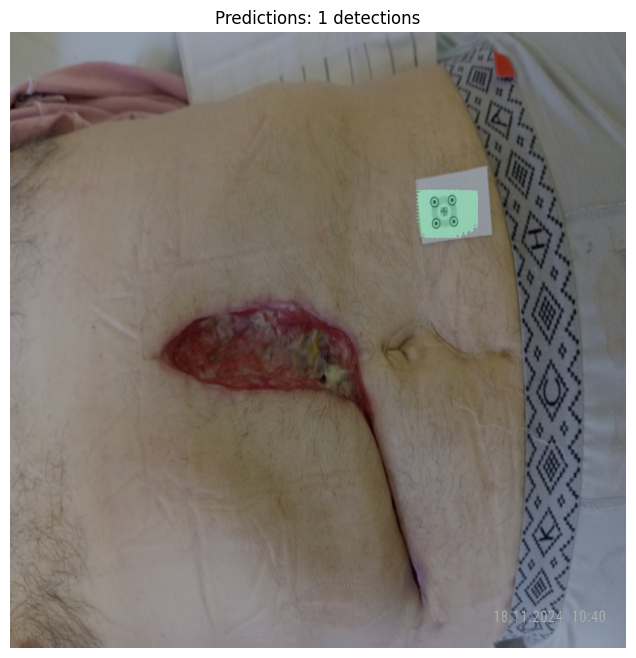


✓ Result saved: ..\results\task_0_image_001_result.json


In [7]:
# ============================================================================
# Load Model and Predict
# ============================================================================

# Load better checkpoint (epoch 15 has better results than best_model.pth)
# best_model.pth is from epoch 7, but epoch 11 had the best val_loss (3.1325)
model_path = Path(CONFIG['checkpoints_dir']) / 'checkpoint_epoch_15.pth'

if model_path.exists():
    print(f"Loading model from: {model_path}")
    checkpoint = torch.load(model_path, map_location=CONFIG['device'], weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✓ Model loaded successfully!")
    if 'epoch' in checkpoint:
        print(f"  - Epoch: {checkpoint['epoch']}")
else:
    print("⚠️ Model not found! Please train the model first (Part 6)")

# تغيير المسار إلى صورة تريد التنبؤ عليها
image_path = 'data/task_0/data/task_0_image_001.jpg'  # ⬅️ عدّل هذا المسار

# Lower confidence threshold for better recall (0.3 instead of 0.5)
CONF_THRESHOLD = 0.3

print("\n" + "=" * 60)
print("Wound Detection - Prediction")
print("=" * 60)
print(f"\nImage: {image_path}")
print(f"Confidence Threshold: {CONF_THRESHOLD}")

# Predict with lower threshold
print("\nPredicting...")
result, predictions = predict_image(image_path, model, CONFIG['device'], conf_threshold=CONF_THRESHOLD)

# Print result
print("\nResults:")
print("-" * 40)
print(f"Detections: {result['num_detections']}")
print(f"Wound Area: {result['wound_area_cm2']} cm²" if result['wound_area_cm2'] else "Wound Area: N/A")
print(f"Infection: {'YES' if result['has_infection'] else 'NO'} (confidence: {result['infection_confidence']:.2f})")
print("\nFindings:")
for finding, present in result['findings'].items():
    print(f"  {finding}: {'✓' if present else '✗'}")

# Visualize
print("\nVisualizing...")
visualize_prediction(image_path, predictions)

# Save result
output_dir = Path(CONFIG['results_dir'])
output_dir.mkdir(exist_ok=True)

result_file = output_dir / f"{Path(image_path).stem}_result.json"
with open(result_file, 'w') as f:
    json.dump(result, f, indent=2)
print(f"\n✓ Result saved: {result_file}")


## run with out train

In [8]:
# ============================================================================
# Quick Start: Load Everything Automatically
# ============================================================================
# Run this cell first when opening a new notebook session!

import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Tuple
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# PyTorch Vision
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

print("=" * 60)
print("✓ Libraries imported!")

# ============================================================================
# Load CONFIG
# ============================================================================
CONFIG = {
    'num_classes': 9,  # Background + 16 classes
    'batch_size': 2,
    'num_workers': 2,
    'learning_rate': 0.0005,
    'num_epochs': 50,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'checkpoints_dir': '../checkpoints_medical_aug',
}

print("✓ CONFIG loaded!")

# ============================================================================
# Build Model
# ============================================================================
def build_model(num_classes=17):
    """بناء Mask R-CNN model"""
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    return model

model = build_model(num_classes=CONFIG['num_classes'])
model.to(CONFIG['device'])
print("✓ Model built!")

# ============================================================================
# Load Trained Model (if exists)
# ============================================================================
# Find project root
current_dir = Path.cwd()
project_root = current_dir
for parent in current_dir.parents:
    if (parent / 'README.md').exists() or (parent / 'requirements.txt').exists():
        project_root = parent
        break
project_root = Path(project_root).resolve()

# Resolve checkpoint path
checkpoints_dir = CONFIG['checkpoints_dir']
if checkpoints_dir.startswith('../') or checkpoints_dir.startswith('..\\'):
    checkpoints_dir = checkpoints_dir.replace('../', '').replace('..\\', '')
checkpoints_dir = project_root / checkpoints_dir

# Use checkpoint_epoch_15 instead of best_model.pth (epoch 15 is closer to best val_loss at epoch 11)
model_path = checkpoints_dir / 'checkpoint_epoch_15.pth'

if model_path.exists():
    print(f"✓ Loading trained model from: {model_path}")
    # weights_only=False is needed to load optimizer_state_dict, epoch, val_loss, etc.
    checkpoint = torch.load(model_path, map_location=CONFIG['device'], weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✓ Trained model loaded successfully!")
    if 'epoch' in checkpoint:
        print(f"  - Epoch: {checkpoint['epoch']}")
    if 'val_loss' in checkpoint:
        print(f"  - Val Loss: {checkpoint['val_loss']:.4f}")
else:
    print(f"⚠️  No trained model found at: {model_path}")
    print("   Run Part 6 (Training) to train a model first.")

print("=" * 60)
print("✅ Quick Start Complete! You can now use the model for prediction.")
print("=" * 60)


✓ Libraries imported!
✓ CONFIG loaded!
✓ Model built!
⚠️  No trained model found at: E:\GitHub\Wound-infection-detection-model\checkpoints_medical_aug\checkpoint_epoch_15.pth
   Run Part 6 (Training) to train a model first.
✅ Quick Start Complete! You can now use the model for prediction.
